In [ ]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

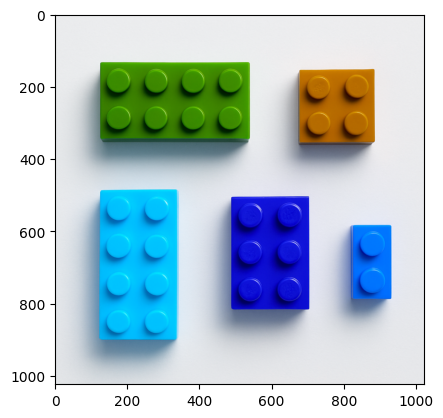

In [2]:
I = cv2.imread('Pictures/lego_2.png')
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

if I is None:
    print("Error: Could not load image. Check file path and format.")
    exit()
    
plt.imshow(I_rgb)
plt.show()

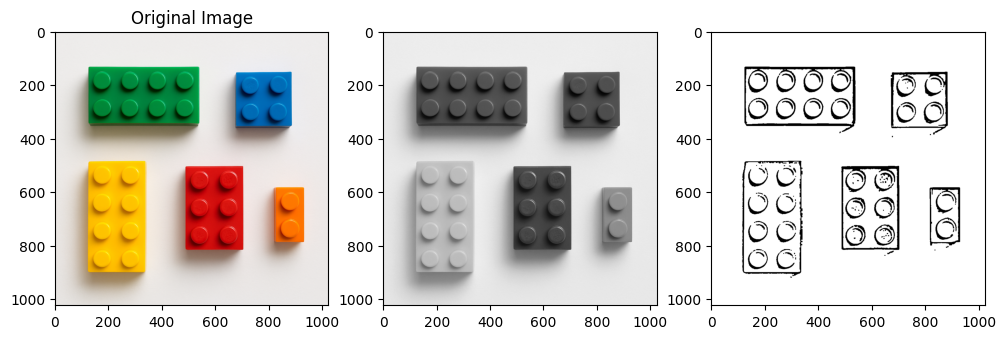

In [3]:
# Grayscale + blur
I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I_blur = cv2.GaussianBlur(I_gray, (5,5), 0)

# Adaptive threshold
#Converted to black and white
B = cv2.adaptiveThreshold(
    I_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    19, 2
)

# Morphology
kernel = np.ones((3,3), np.uint8)
#close = fill small holes
#open = removes small white noise outside objects
B_clean = cv2.morphologyEx(B, cv2.MORPH_CLOSE, kernel, iterations=2) 
B_clean = cv2.morphologyEx(B_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours
contours, hierarchy = cv2.findContours(B_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by area to get only LEGO blocks
min_area = 800
lego_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

print(f"Total number of LEGO blocks detected: {len(lego_contours)}")

# Create filled mask visualization
I_filled = np.ones_like(I_rgb) * 255  # white background
cv2.drawContours(I_filled, lego_contours, -1, (0, 0, 0), thickness=cv2.FILLED)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(I_rgb)
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(I_gray, cmap='gray')
plt.title("Gray Scale")

plt.subplot(1,3,3)
plt.imshow(I_filled)
plt.title(f"LEGO Blocks Filled Mask ({len(lego_contours)} blocks)")
plt.show()

In [ ]:
# Calculate grid size for displaying all blocks
num_blocks = len(lego_contours)
cols = 4  # Display 4 blocks per row
rows = (num_blocks + cols - 1) // cols  # Calculate needed rows
plt.figure(figsize=(15, 3*rows))

#Looping through each LEGO block
for idx, contour in enumerate(lego_contours, 1):
    # Get bounding box
    x, y, w, h = cv2.boundingRect(contour)
    
    # Add padding
    padding = 5
    y_min = max(0, y - padding) #Don't go below 0
    y_max = min(I_rgb.shape[0], y + h + padding) #Image height cannot be exceeded
    x_min = max(0, x - padding) #Don't go left of 0
    x_max = min(I_rgb.shape[1], x + w + padding) #Image width cannot be exceeded
    
    # Create mask directly in the cropped region size
    mask_region = np.zeros((y_max - y_min, x_max - x_min), dtype=np.uint8)
    
    # Adjust contour coordinates to the cropped region
    contour_shifted = contour - [x_min, y_min]
    cv2.drawContours(mask_region, [contour_shifted], -1, 255, thickness=cv2.FILLED)
    
    # Extract the block region from original image
    block_original = I_rgb[y_min:y_max, x_min:x_max].copy()
    
    # Create a white background version
    block_display = np.ones_like(block_original) * 255
    block_display[mask_region > 0] = block_original[mask_region > 0]
    
    # Display
    plt.subplot(rows, cols, idx)
    plt.imshow(block_display)
    plt.title(f"Block {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
#test commit :)

Piece 1: 2 circles detected
Piece 2: 6 circles detected
Piece 3: 4 circles detected
Piece 4: 8 circles detected


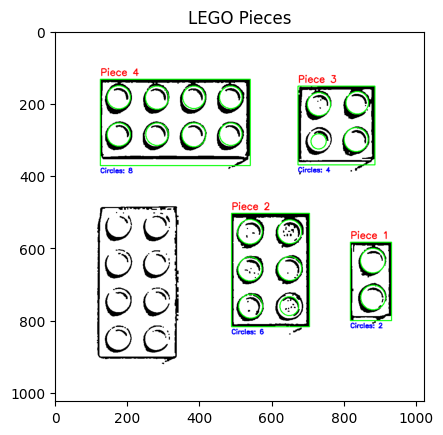

In [5]:
#Automatically detect lego pieces using countouring

#Threshold to convert pixels less than 100 to 0 and pixels greater than or equal to 100 to 255 then inverting it
_, thresh = cv2.threshold(B_inverted, 100, 255, cv2.THRESH_BINARY_INV)

#This is used to clean the image before contouring it
k = np.ones((5,5), np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, k)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, k)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = cv2.cvtColor(B_inverted, cv2.COLOR_GRAY2BGR)
piece_count = 0
filtered_contour = []

#This loops through each lego piece that it was able to contour
for c in contours:
    area = cv2.contourArea(c) #Computes area in pixels of contour
    #This filters out small contours (noise)
    if area > 2000:
        filtered_contour.append(c)
        x, y, w, h = cv2.boundingRect(c)
        piece_count += 1

        #This creates a bounding box around the lego piece
        cv2.rectangle(output, (x,y), (x+w, y+h), (0,255,0), 2) #green rectangle 
        cv2.putText(output, f"Piece {piece_count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2) #puts a label on the image of the piece number

        #Crops the grayscale image so that it can count the number of circles on a specific piece 
        lego_piece = I_gray[y:y+h, x:x+w]

        #Cleans the lego piece to reduce noise and improve contrast
        C_cleaned = cv2.medianBlur(lego_piece, 5)
        C_cleaned = cv2.equalizeHist(C_cleaned)

        #This detects circular shapes in the cropped piece
        circles = cv2.HoughCircles(
            C_cleaned,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=100,
            param1=100,
            param2=40,
            minRadius=10,
            maxRadius=60
        )
        
        #Checks if any circles were found or not
        if circles is not None:
            circles = np.uint16(np.around(circles))
            count = circles.shape[1] #counts the number or circles in the piece
            print(f"Piece {piece_count}: {count} circles detected")

            #Loops through each circle
            for (cx, cy, r) in circles[0, :]: 
                cv2.circle(output, (x + cx, y + cy), r, (0, 255, 0), 2) # draws the circle in green 

            #Writes text to count number of circles on that specific piece
            cv2.putText(output, f"Circles: {count}", (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        else: 
            print(f"Piece {piece_count}: No circles detected")

# cv2.drawContours(output, contours, -1, (0,255,0), 2)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("LEGO Pieces")
plt.show()
